# I will get this model to work today.
today.

In [506]:
import math
from itertools import product
import random
import pandas as pd
import torch
from torch import Tensor, LongTensor
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric
from torch_geometric.data import Data
from torch_geometric.data import Dataset
import matplotlib.pyplot as plt

In [491]:
def compute_distance(pos1: Tensor, pos2: Tensor) -> float:
    return torch.sum(torch.pow(torch.sub(pos1, pos2), 2)).item()

In [559]:
node_features_df = pd.read_csv('baby_QM9/raw/node_attributes.txt', header=None)
node_features = torch.tensor(node_features_df.values)
graph_features_df = pd.read_csv('baby_QM9/raw/Y.txt', header=None)
graph_features = torch.tensor(graph_features_df.values)
atomic_numbers = node_features[:,5].long()
positions = node_features[:,-3:]
atomization_energies = graph_features[:,13]
atomization_energies_list = atomization_energies.tolist()

In [560]:
new_graph_node_indices = [0]
node_indicators_df = pd.read_csv('baby_QM9/raw/graph_indicator.txt', header=None)
node_indicators = node_indicators_df.values.tolist()
for ix in range(len((node_indicators)))[1:]:
    if node_indicators[ix] != node_indicators[ix-1]:
        new_graph_node_indices.append(ix)
new_graph_node_indices.append(len(node_indicators))

In [561]:
def make_complete_edge_indices(n: int) -> LongTensor:
    edges = list(filter(lambda e: e[0] != e[1], product(range(n), range(n))))
    return torch.tensor(edges, dtype=torch.long).T

In [499]:
def make_edge_distances(node_positions: Tensor) -> Tensor:
    edge_distances = torch.zeros(positions.size()[0], positions.size()[0])
    for ix, source_position in enumerate(node_positions):
        for jx, destination_position in enumerate(node_positions):
            edge_distances[ix][jx] = compute_distance(source_position, destination_position)
    return edge_distances

In [565]:
molecules_list = []

for start, end in zip(new_graph_node_indices, new_graph_node_indices[1:]):
    x = atomic_numbers.clone()[start:end].view(-1, 1)
    edge_index = make_complete_edge_index(end-start)
    y = torch.Tensor([atomization_energies_list.pop(0)])
    pos = positions.clone()[start:end]
    edge_distances = make_edge_distance_tensor(pos)
    molecule = Data(x = x, edge_index = edge_index, y = y, pos = pos, edge_distances = edge_distances)
    molecules_list.append(molecule)

In [575]:
class MoleculesDataset(Dataset):
    def __init__(self, data: List[Data]) -> None:
        super().__init__()
        self.data = data
        
    def len(self) -> int:
        return len(self.data)
    
    def get(self, idx: int) -> Data:
        return self.data[idx]

molecules_dataset = MoleculesDataset(molecules_list)

In [599]:
class EVMPLayer(nn.Module):
    def __init__(self, embed_dim: int) -> None:
        super(EVMPLayer, self).__init__()
        self.embed_dim = embed_dim
        self.act = nn.ReLU()
        message_input_size = 2 * embed_dim + 1
        
        # take in a message tensor of size 2 * embed_dim + 1 and get out a new h_i of size embed_dim
        self.message_mlp = nn.Sequential(nn.Linear(message_input_size, embed_dim), self.act)
        
        # take in a message tensor of size embed_dim and an original h_i of size embed_dim and get out a new h_i of size embed_dim
        self.node_update_mlp = nn.Sequential(nn.Linear(2 * embed_dim, embed_dim), self.act)
                
    def make_message(self, source_tensor: int, target_tensor: int, distance: float) -> Tensor:
        message_tensor = torch.cat((source_tensor.view(-1), target_tensor.view(-1), torch.Tensor([distance])), dim=0)
        return self.message_mlp(message_tensor)
    
    def update_node(self, node_tensor: Tensor, message_tensor: Tensor) -> Tensor:
        combined_tensor = torch.cat((node_tensor, message_tensor), dim=0).view(1,-1)
        return self.node_update_mlp(combined_tensor)
    
    def forward(self, embed_tensor: Tensor, edge_distances: Tensor) -> Tensor:
        new_embed_tensor = torch.zeros_like(embed_tensor)
        # for each molecule in the dataset
        for ix, source in enumerate(embed_tensor):
            # create a tensor that tracks the sum of the messages
            message_sum = torch.zeros_like(source)
            # for each other molecule in the dataset
            for jx, target in enumerate(embed_tensor):
                if ix != jx:
                    # add the message tensor between them to the sum tensor
                    message_sum += self.make_message(source, target, edge_distances[ix,jx].item())
            # update the tensor that keeps track of all molecule embeddings by making its row ix the new embedding of the molecule
            new_embed_tensor[ix] = self.update_node(source, message_sum)
        
        return new_embed_tensor
            

In [615]:
class RowWiseFCL(nn.Module): 
    def __init__(self, in_dim: int, out_dim: int) -> None: 
        super(RowWiseFCL, self).__init__() 
        self.out_dim = out_dim
        self.row_layer = nn.Sequential(nn.Linear(in_dim, out_dim), nn.ReLU())
      
    def forward(self, in_tensor) -> Tensor:
        out_tensor = torch.zeros(in_tensor.size()[0], self.out_dim)
        for ix, row in enumerate(in_tensor):
            out_tensor[ix] = self.row_layer(row)
        return out_tensor

In [616]:
class EVGNN(nn.Module):
    def __init__(self) -> None:
        super(EVGNN, self).__init__()
        
        loss_function = nn.MSELoss()
        
        self.embedding = nn.Embedding(118, 8)
        self.mp1 = EVMPLayer(8)
        self.mp2 = EVMPLayer(8)
        self.prediction1 = RowWiseFCL(8, 1) 
        # self.prediction2 = RowWiseFCL(8, 1)

    def forward(self, data = Data) -> float:
        print('IN MODEL', data)
        x = self.embedding(data['x'])
        print('EMBEDDING', x)
        x = self.mp1(x, data.edge_distances)
        print('MESSAGE PASSING 1', x)
        x = self.mp2(x, data.edge_distances)
        print('MESSAGE PASSING 2', x)
        x = self.prediction1(x)
        print('PREDICTION 1', x)
        # x = self.prediction2(x)
        # print('PREDICTION 2', x)
        U_hat = torch.sum(x)
        
        return U_hat

In [628]:
def criterion(pred: float, target: float) -> float:
    return torch.mean((pred - target) ** 2)

model = EVGNN()
optim = torch.optim.Adam(model.parameters(), lr=0.001)
losses = []
epoch_mean_losses = []
epochs = range(1)

# training loop
model.train()
for epoch in epochs:
    epoch_mean_loss = 0
    for data in molecules_dataset[:100]:
        U_hat = model(data)
        U = data['y']
        Us_squared.append(U**2)
        loss = criterion(U_hat, U)
        epoch_mean_loss += loss.item()
        losses.append(loss.item())
        optim.zero_grad()
        loss.backward()
        optim.step()
    epoch_mean_loss /= len(dataset)
    # print('EPOCH #', epoch, '| MEAN LOSS', epoch_mean_loss)
    epoch_mean_losses.append(epoch_mean_loss)
    
    
# model.eval()
# for data in loader:
#     pred = model(data)
#     target = data.y
#     preds.append(pred)
#     targets.append(target)
#     test_mae += total_absolute_error(pred, target).item()

IN MODEL Data(x=[5, 1], edge_index=[2, 20], y=[1], pos=[5, 3], edge_distances=[5, 5])
EMBEDDING tensor([[[ 0.4267, -0.9414, -0.6913, -0.4407,  0.3719, -0.7631,  0.3581,
           1.4113]],

        [[-0.7253,  0.8114,  0.0037, -1.1172,  2.6447, -0.7989, -0.7231,
          -0.2000]],

        [[-0.7253,  0.8114,  0.0037, -1.1172,  2.6447, -0.7989, -0.7231,
          -0.2000]],

        [[-0.7253,  0.8114,  0.0037, -1.1172,  2.6447, -0.7989, -0.7231,
          -0.2000]],

        [[-0.7253,  0.8114,  0.0037, -1.1172,  2.6447, -0.7989, -0.7231,
          -0.2000]]], grad_fn=<EmbeddingBackward0>)
MESSAGE PASSING 1 tensor([[[1.4830, 1.0084, 0.5376, 0.0000, 0.0000, 0.9525, 0.0000, 0.0000]],

        [[1.3039, 0.4114, 0.5687, 0.6419, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[1.3039, 0.4114, 0.5687, 0.6419, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[1.3039, 0.4114, 0.5687, 0.6419, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[1.3039, 0.4114, 0.5687, 0.6419, 0.0000, 0.0000, 0.0000, 0.0000]

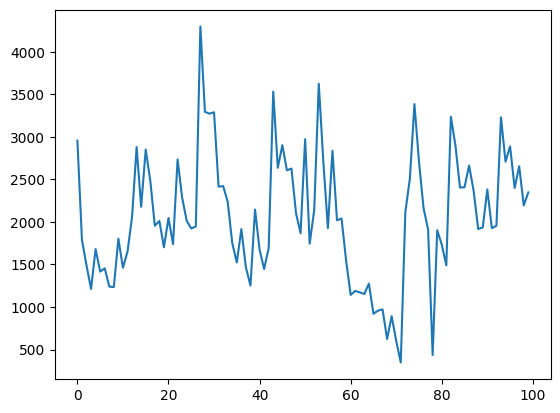

In [630]:
import matplotlib.pyplot as plt

xs = [x for x in range(len(losses))]

# plt.plot(xs, losses)
plt.plot(xs, losses)
plt.show()
# Make sure to close the plt object once done
plt.close()